# Intro to Generalized Linear Models and Other Extensions

![](http://www.quickmeme.com/img/41/41d0ede8c93c189f045c45250287c93267b88ee7fdf84617e65a10364b663c09.jpg)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingRegressor

import gc; gc.enable()

import warnings
warnings.filterwarnings("ignore")

## Toy Problem

Suppose we have data $X_1, X_2, \dots, X_{14}$ with response $y$ such that

$$
y = 10 \sin(\pi X_1 X_2) + 20 (X_3 - 0.5)^2 + 10 X_4 + 5 X_5 + \epsilon
$$

where:
* $X_i \sim \textrm{Uniform[0,1]}$ for $1 \leq i \leq 5$,
* $\epsilon \sim N(0,1) \quad (\textrm{white noise})$,
* $X_i$ are independent of the response $y$ for $6 \leq i \leq 10$,
* $X_{i+10} = X_i + N(0,0.025)$ are strongly correlated (redundant) signals for $1 \leq i \leq 4$.

In [2]:
np.random.seed(0)
 
size = 750
X = np.random.uniform(0, 1, (size, 14))
 
# Classic regression problem
Y = (10 * np.sin(np.pi*X[:,0]*X[:,1]) + 20*(X[:,2] - .5)**2 +
     10*X[:,3] + 5*X[:,4] + np.random.normal(0,1))
# Add additional correlated (redundant) variables 
X[:,10:] = X[:,:4] + np.random.normal(0, .025, (size,4))
 
names = ["x%s" % i for i in range(1,15)]

## Quick Look

In [3]:
target = 'y'
cols = names + [target]
df = pd.DataFrame(np.concatenate((X, Y.reshape(-1,1)),axis=1), columns=cols)

def peek():
    return df.head(3).append(df.tail(3))

peek()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,y
0,0.548814,0.715189,0.602763,0.544883,0.423655,0.645894,0.437587,0.891773,0.963663,0.383442,0.590706,0.703692,0.605185,0.567413,17.568016
1,0.071036,0.087129,0.020218,0.832620,0.778157,0.870012,0.978618,0.799159,0.461479,0.780529,0.055713,0.101148,0.064145,0.849744,17.369746
2,0.521848,0.414662,0.264556,0.774234,0.456150,0.568434,0.018790,0.617635,0.612096,0.616934,0.517176,0.404405,0.228446,0.772927,17.772757
747,0.325059,0.168457,0.118491,0.697574,0.993262,0.391915,0.763739,0.654240,0.420962,0.048934,0.313548,0.186391,0.063740,0.696271,16.919377
748,0.579240,0.940735,0.576025,0.172329,0.951614,0.187940,0.128146,0.362451,0.434851,0.977373,0.580249,0.971869,0.590614,0.207919,16.852105
749,0.074649,0.119731,0.992717,0.859945,0.345718,0.832780,0.899867,0.923395,0.875206,0.186220,0.098751,0.126961,0.998421,0.864668,15.818729


In [4]:
df.corr()[target].abs().sort_values(ascending=False)

y      1.000000
x4     0.581327
x14    0.579031
x2     0.429739
x12    0.428341
x1     0.364837
x11    0.359157
x5     0.221490
x8     0.103075
x7     0.075022
x9     0.068373
x3     0.025026
x13    0.024651
x10    0.014190
x6     0.003067
Name: y, dtype: float64

In [5]:
used_cols = [c for c in df.columns.tolist() if c not in [target]]
X, y = df[used_cols], df[target]

## Linear Model - Baseline

------------------------------------------------------------
test_r2 :
					 0.7393 +/- 0.0391
train_r2 :
					 0.7638 +/- 0.0178

------------------------------------------------------------
test_neg_mean_absolute_error :
					 -1.8746 +/- 0.0601
train_neg_mean_absolute_error :
					 -1.8009 +/- 0.0342

------------------------------------------------------------
test_neg_mean_squared_error :
					 -5.8590 +/- 0.6608
train_neg_mean_squared_error :
					 -5.3430 +/- 0.3074

------------------------------------------------------------
Beta_1 :	 7.7873 +/- 3.2113
Beta_2 :	 4.1931 +/- 1.9065
Beta_3 :	 -4.1974 +/- 4.1094
Beta_4 :	 4.3235 +/- 2.1593
Beta_5 :	 2.2700 +/- 0.2324
Beta_6 :	 0.2305 +/- 0.2404
Beta_7 :	 0.0405 +/- 0.2189
Beta_8 :	 0.3197 +/- 0.2452
Beta_9 :	 0.1033 +/- 0.1665
Beta_10 :	 -0.0540 +/- 0.1605
Beta_11 :	 -4.6204 +/- 3.2580
Beta_12 :	 -0.6260 +/- 2.1435
Beta_13 :	 4.1083 +/- 3.9988
Beta_14 :	 0.7240 +/- 1.9446

----------------------------------------------------------

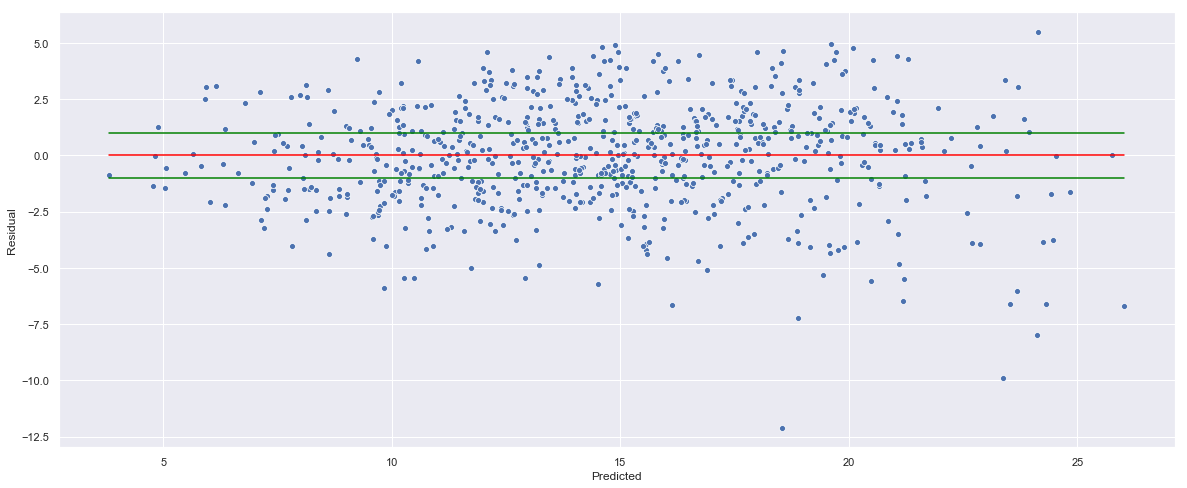

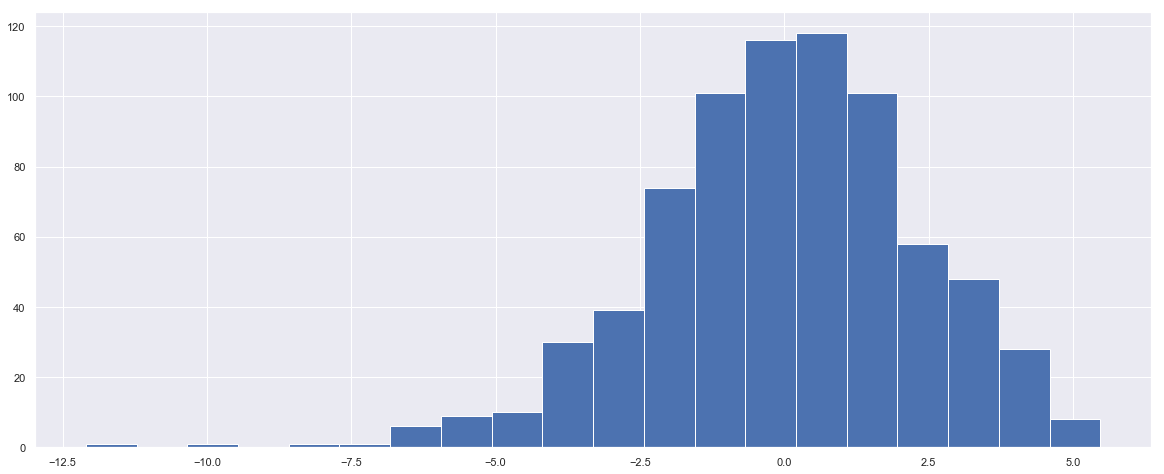

In [6]:
# Baseline : Linear (OLS) Regression
scaler = RobustScaler()
lr = LinearRegression()
pipe1 = make_pipeline(scaler, lr)


# Quick helper functions
def model_evaluate(old_pipe, bagging=True):
    if bagging:
        pipe = BaggingRegressor(old_pipe, n_estimators=3)
    else:
        pipe = old_pipe
        
    metrics = ['r2', 
               'neg_mean_absolute_error', 
               'neg_mean_squared_error']
    preds = cross_validate(pipe, X, y, 
                           cv=3, n_jobs=-1, 
                           scoring=metrics,
                           return_estimator=True)

    print("-"*60)
    for i, tag in enumerate(preds):
        if 'time' not in tag and 'estimator' not in tag:
            print(tag, ":\n\t\t\t\t\t", 
                  "%.4f" % preds[tag].mean(), 
                  "+/-", 
                  "%.4f" % preds[tag].std())
            if i % 2 == 0:
                print()
                print("-"*60)
                
    if bagging:
        coeffs = []
        for i in range(3):
            for j in range(3):
                estimator = preds['estimator'][i].estimators_[j]
                modeling_step = estimator.steps[1][0]
                coef = estimator.named_steps[modeling_step].coef_
                coeffs.append(coef)

        coeffs = [(
            "Beta_%s" % (i+1), 
            "%.4f" % np.mean(coeffs, axis=0)[i],
            "%.4f" % np.std(coeffs, axis=0)[i],
        ) for i in range(len(used_cols))]
        for coeff in coeffs:
            print(coeff[0], ":\t", coeff[1], "+/-", coeff[2])

        print()
        print("-"*60)
        
    return preds['estimator']


def model_predict(pipe):
    y_preds = [pipe[i].predict(X) for i in range(len(pipe))]
    y_pred = np.mean(y_preds, axis=0)
    return y_pred


def plot_residuals():
    SIZE = (20,8)

    plt.figure(figsize=SIZE)
    sns.scatterplot(y_pred, (y - y_pred))
    sns.lineplot(y_pred, [0]*len(y_pred), color='red')
    sns.lineplot(y_pred, [1]*len(y_pred), color='green')
    sns.lineplot(y_pred, [-1]*len(y_pred), color='green')
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.show()

    plt.figure(figsize=SIZE)
    plt.hist(y - y_pred, bins=20)
    # TODO: Add vertical lines at x=-1,0,1
    plt.show()


pipe1 = model_evaluate(pipe1)
y_pred = model_predict(pipe1)
plot_residuals()

## Feature Selection Using $L_1$-Regularization

![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS63hhb4vMen4XZ0HclB9xpKmzYOFuGY7n3aeYQq5JZSagp-9b8)

Let's see if we can improve the linear baseline by removing some irrelevant features.

------------------------------------------------------------
test_r2 :
					 0.7389 +/- 0.0454
train_r2 :
					 0.7511 +/- 0.0227

------------------------------------------------------------
test_neg_mean_absolute_error :
					 -1.9155 +/- 0.0919
train_neg_mean_absolute_error :
					 -1.8829 +/- 0.0481

------------------------------------------------------------
test_neg_mean_squared_error :
					 -5.8644 +/- 0.8036
train_neg_mean_squared_error :
					 -5.6281 +/- 0.3989

------------------------------------------------------------
Beta_1 :	 2.8381 +/- 0.1405
Beta_2 :	 2.2331 +/- 1.2082
Beta_3 :	 -0.0530 +/- 0.1499
Beta_4 :	 3.8562 +/- 1.5052
Beta_5 :	 1.9292 +/- 0.2493
Beta_6 :	 0.0129 +/- 0.1052
Beta_7 :	 0.0129 +/- 0.0263
Beta_8 :	 0.0714 +/- 0.0877
Beta_9 :	 0.0044 +/- 0.0124
Beta_10 :	 -0.0457 +/- 0.1292
Beta_11 :	 0.0000 +/- 0.0000
Beta_12 :	 1.0456 +/- 1.1640
Beta_13 :	 -0.0044 +/- 0.0488
Beta_14 :	 0.7789 +/- 1.2279

-----------------------------------------------------------

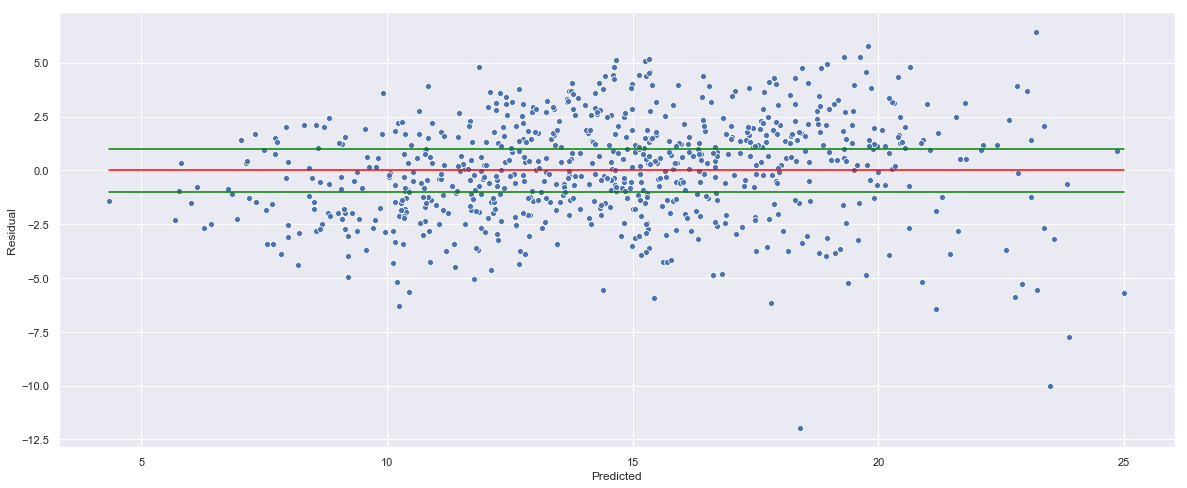

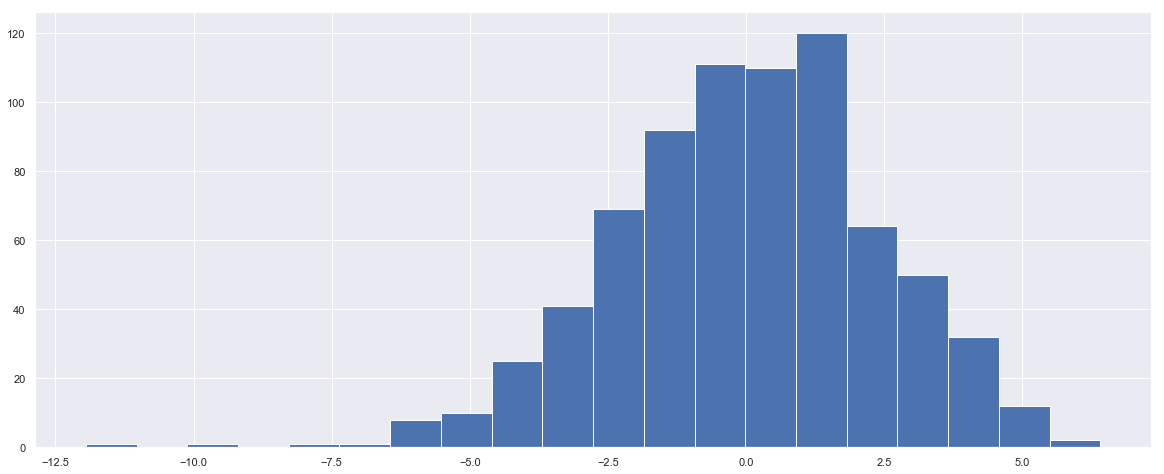

In [7]:
# Second attempt : L1-Regularization to remove uninformative features
lasso = Lasso(alpha=0.1)
pipe2 = make_pipeline(scaler, lasso)

pipe2 = model_evaluate(pipe2)
y_pred = model_predict(pipe2)
plot_residuals()

## A Second Look

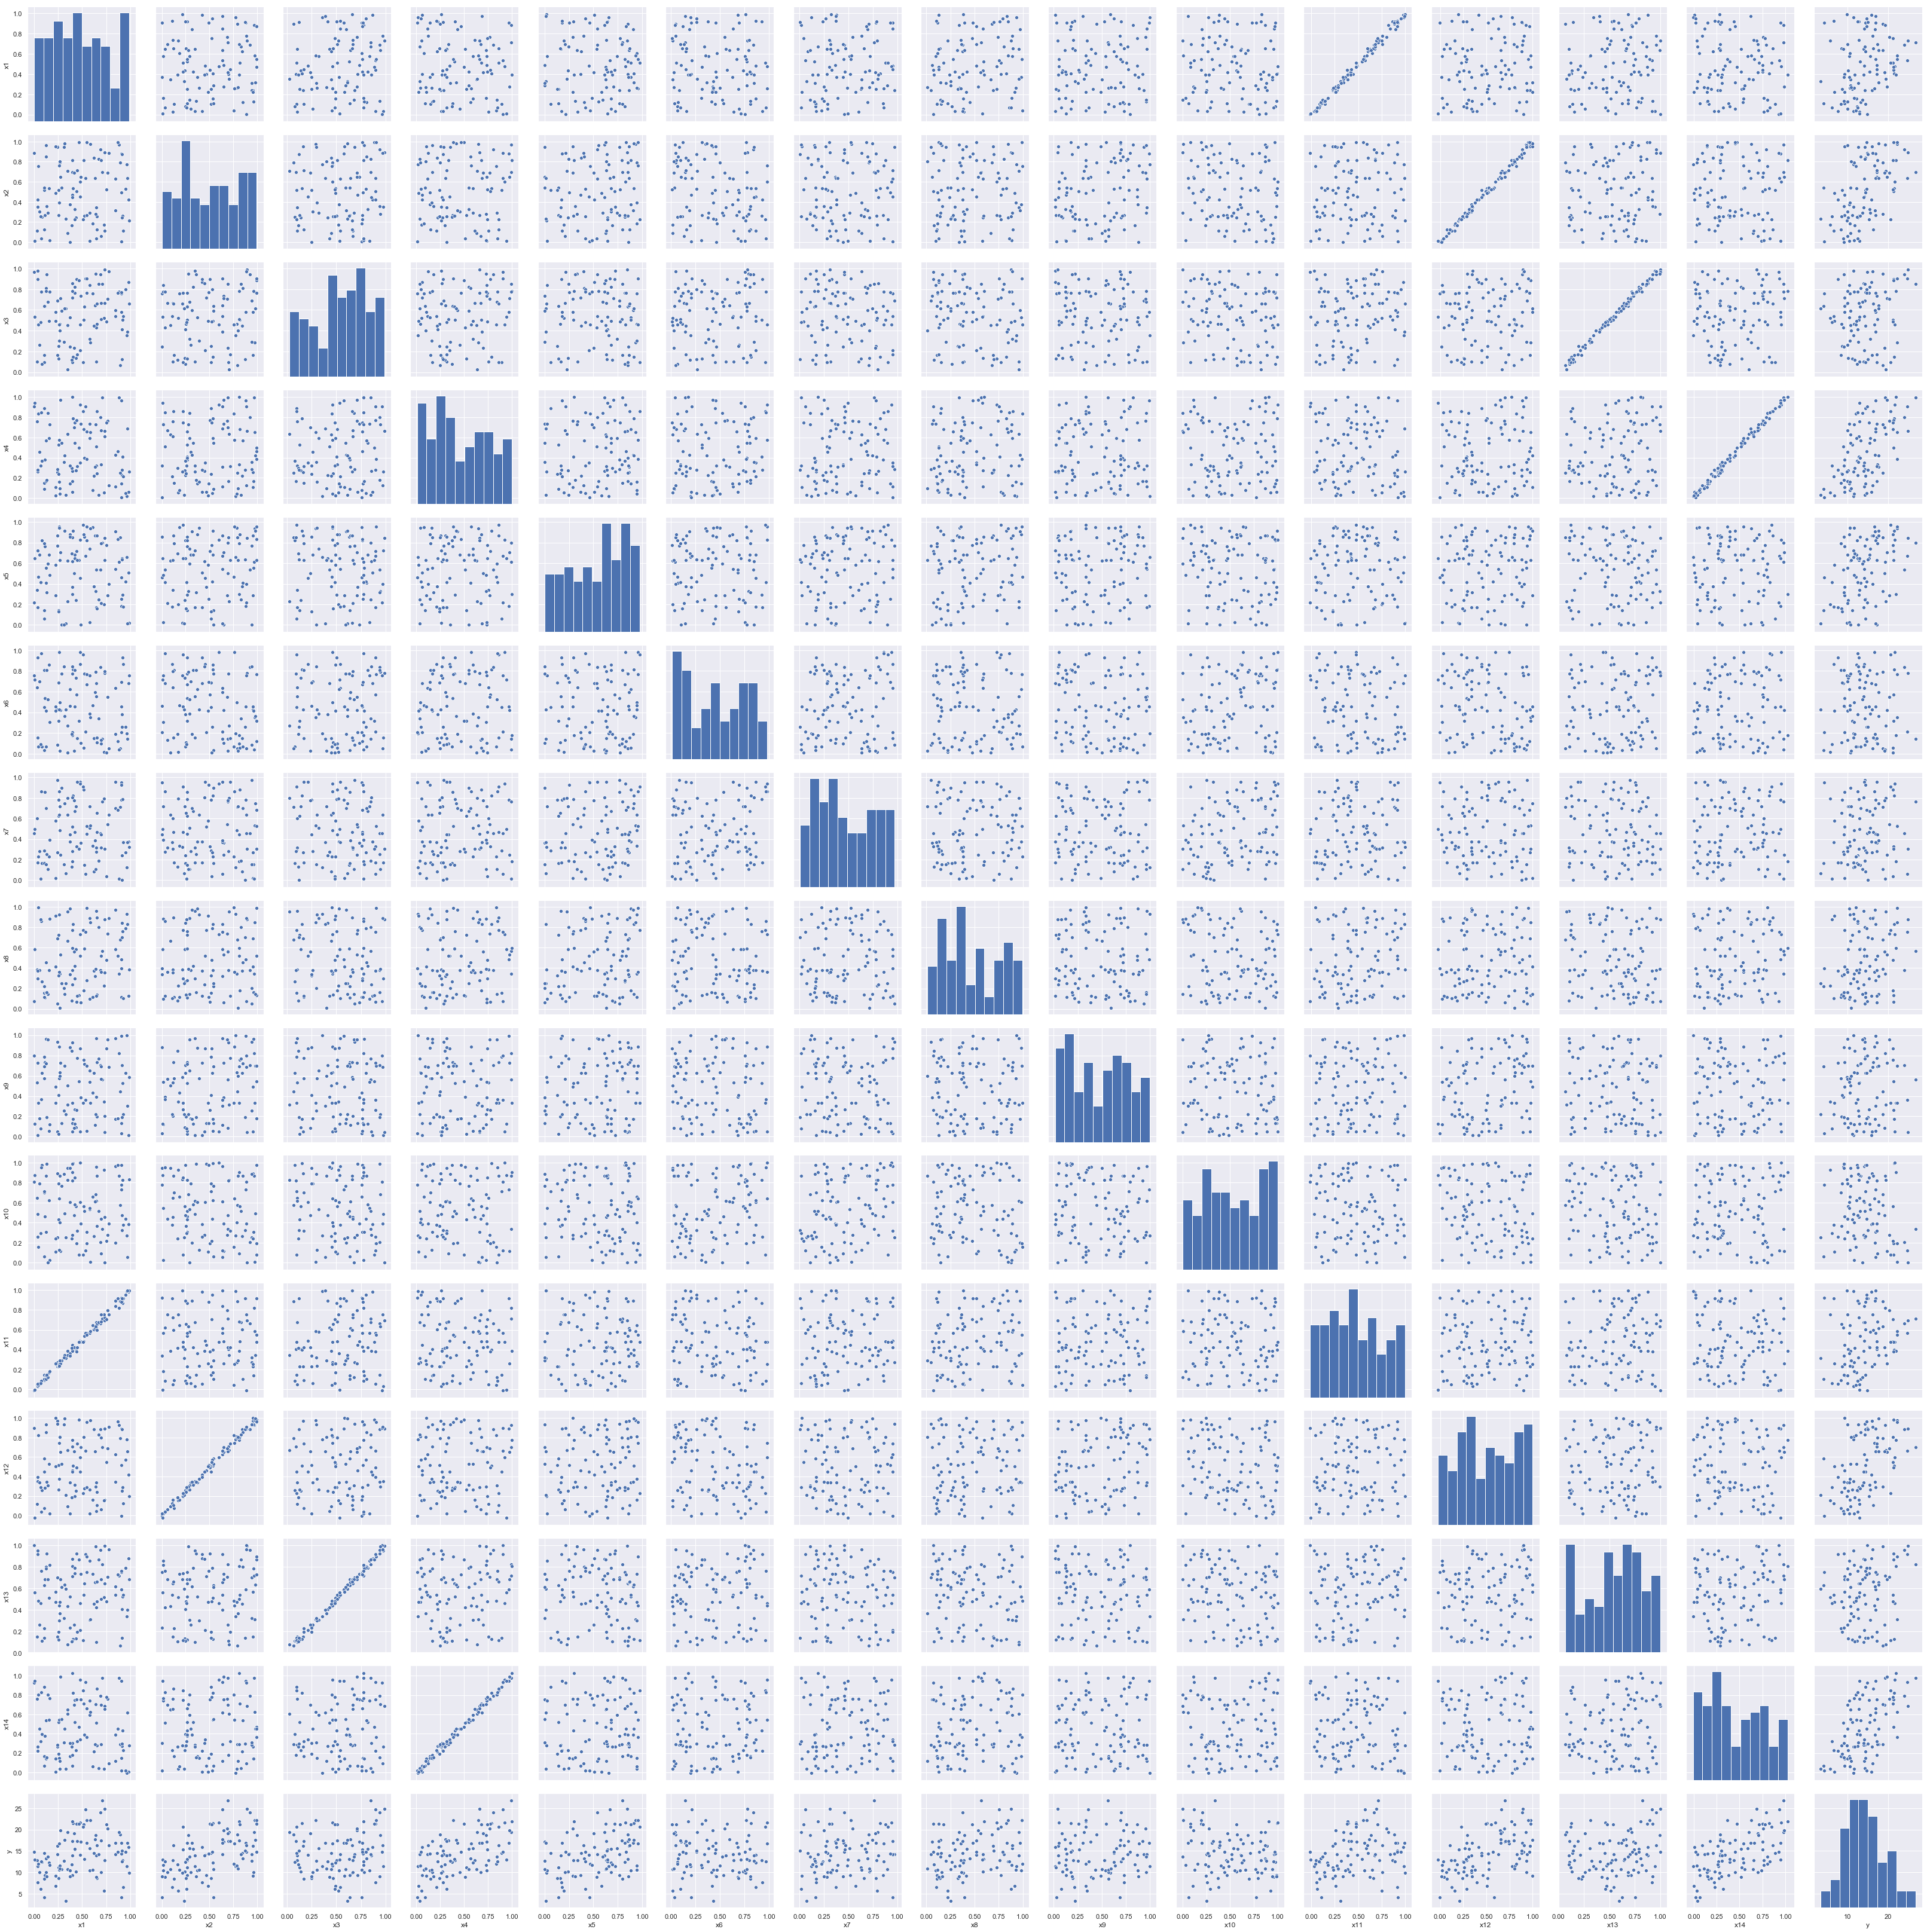

In [8]:
samp = df.sample(100)
sns.pairplot(samp, height=3)
plt.show()

## Dealing with Redundancies

![](https://miro.medium.com/max/1000/0*Nz9PiF00jajbPslo.jpg)

In [9]:
for i in range(1,5):
    df['x'+str(i)] += df['x'+str(i+10)]
    df['x'+str(i)] /= 2
    del df['x'+str(i+10)];

used_cols = [c for c in df.columns.tolist() if c not in [target]]
X, y = df[used_cols], df[target]    
gc.collect();

peek()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.569760,0.709441,0.603974,0.556148,0.423655,0.645894,0.437587,0.891773,0.963663,0.383442,17.568016
1,0.063374,0.094139,0.042182,0.841182,0.778157,0.870012,0.978618,0.799159,0.461479,0.780529,17.369746
2,0.519512,0.409533,0.246501,0.773580,0.456150,0.568434,0.018790,0.617635,0.612096,0.616934,17.772757
747,0.319304,0.177424,0.091115,0.696922,0.993262,0.391915,0.763739,0.654240,0.420962,0.048934,16.919377
748,0.579745,0.956302,0.583319,0.190124,0.951614,0.187940,0.128146,0.362451,0.434851,0.977373,16.852105
749,0.086700,0.123346,0.995569,0.862306,0.345718,0.832780,0.899867,0.923395,0.875206,0.186220,15.818729


## Update Baseline and Second Model

------------------------------------------------------------
test_r2 :
					 0.7426 +/- 0.0456
train_r2 :
					 0.7547 +/- 0.0213

------------------------------------------------------------
test_neg_mean_absolute_error :
					 -1.8578 +/- 0.0585
train_neg_mean_absolute_error :
					 -1.8166 +/- 0.0407

------------------------------------------------------------
test_neg_mean_squared_error :
					 -5.7711 +/- 0.7556
train_neg_mean_squared_error :
					 -5.5461 +/- 0.3704

------------------------------------------------------------
Beta_1 :	 3.3779 +/- 0.3217
Beta_2 :	 3.5930 +/- 0.3765
Beta_3 :	 -0.0499 +/- 0.2013
Beta_4 :	 5.3689 +/- 0.3762
Beta_5 :	 2.2275 +/- 0.1652
Beta_6 :	 0.1745 +/- 0.1593
Beta_7 :	 -0.0092 +/- 0.2361
Beta_8 :	 0.2241 +/- 0.2535
Beta_9 :	 -0.0183 +/- 0.2387
Beta_10 :	 -0.1196 +/- 0.1134

------------------------------------------------------------


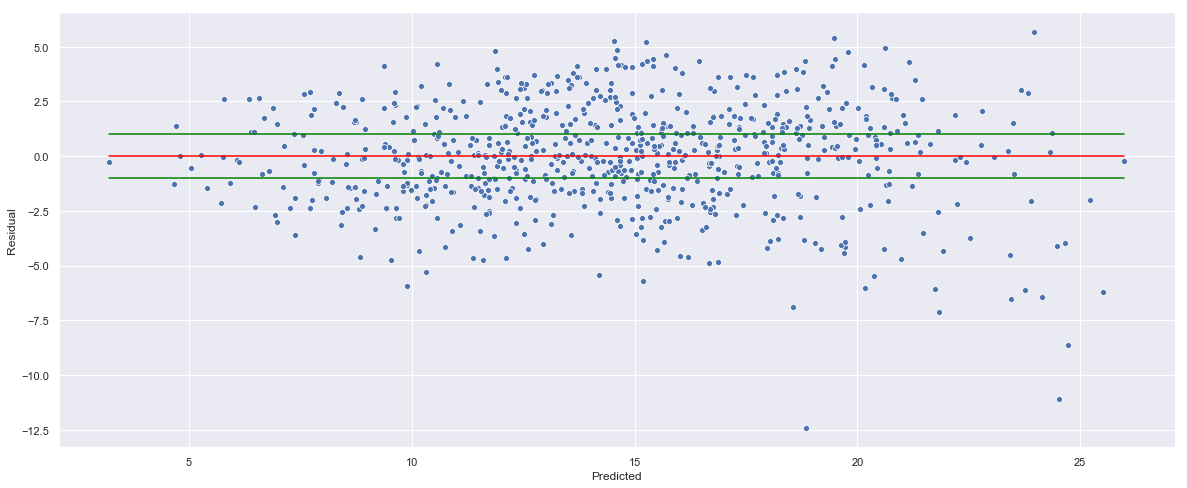

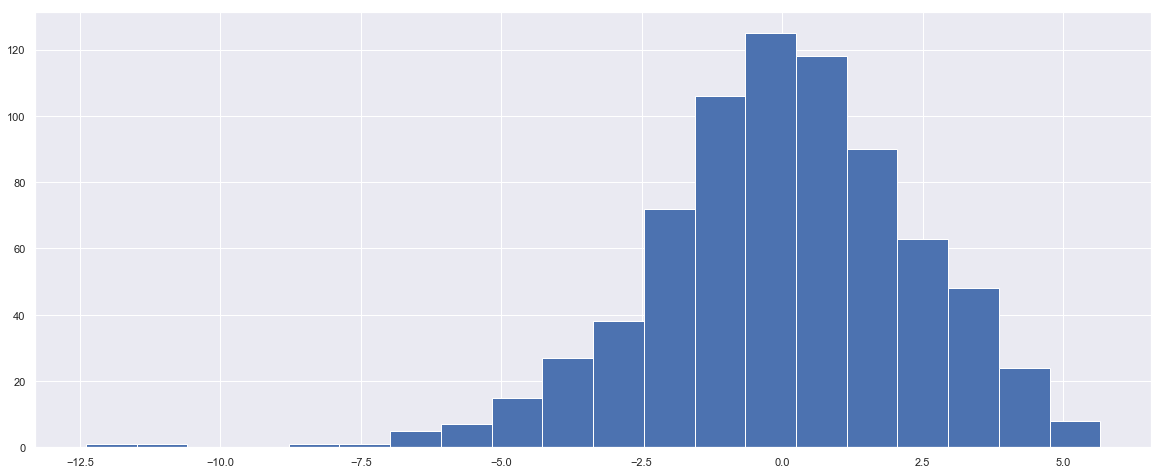

------------------------------------------------------------
test_r2 :
					 0.7404 +/- 0.0454
train_r2 :
					 0.7485 +/- 0.0207

------------------------------------------------------------
test_neg_mean_absolute_error :
					 -1.9098 +/- 0.0987
train_neg_mean_absolute_error :
					 -1.8917 +/- 0.0367

------------------------------------------------------------
test_neg_mean_squared_error :
					 -5.8320 +/- 0.8108
train_neg_mean_squared_error :
					 -5.6866 +/- 0.3503

------------------------------------------------------------
Beta_1 :	 2.9630 +/- 0.3545
Beta_2 :	 3.1072 +/- 0.3183
Beta_3 :	 -0.0637 +/- 0.1036
Beta_4 :	 4.9094 +/- 0.4832
Beta_5 :	 2.0775 +/- 0.2836
Beta_6 :	 0.0461 +/- 0.0870
Beta_7 :	 0.0520 +/- 0.0747
Beta_8 :	 0.0792 +/- 0.0966
Beta_9 :	 0.0000 +/- 0.0000
Beta_10 :	 0.0000 +/- 0.0000

------------------------------------------------------------


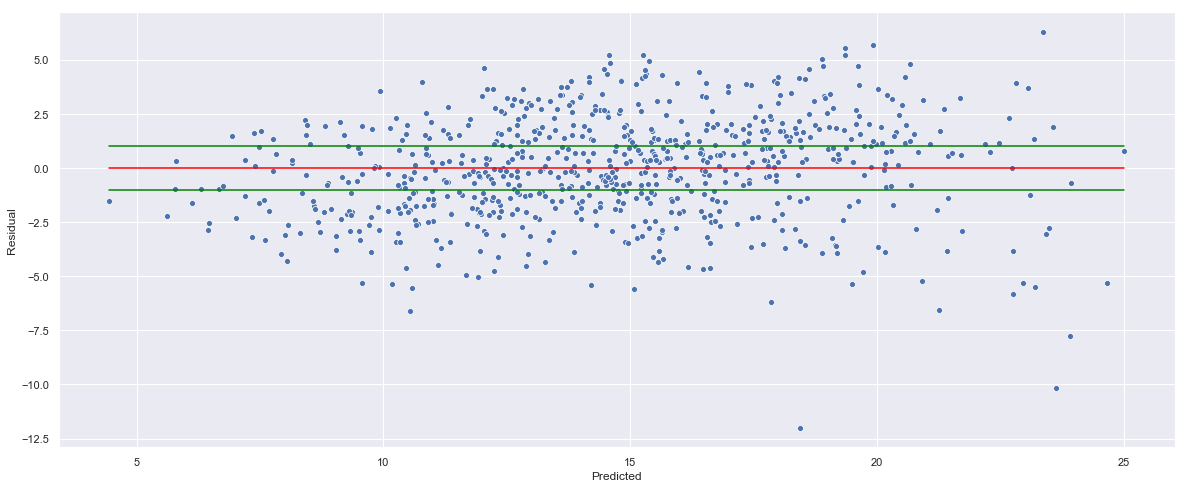

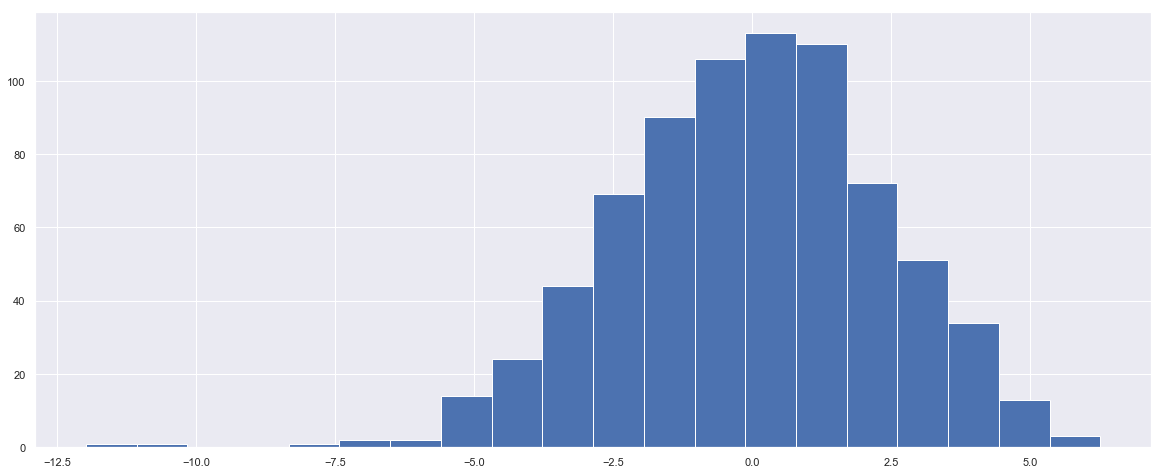

In [10]:
pipe1 = make_pipeline(scaler, lr)
pipe1 = model_evaluate(pipe1)
y_pred = model_predict(pipe1)
plot_residuals()

pipe2= make_pipeline(scaler, lasso)
pipe2 = model_evaluate(pipe2)
y_pred = model_predict(pipe2)
plot_residuals()

## Adding Feature Engineering to Your Pipeline

![](https://i1.wp.com/www.padtinc.com/blog/wp-content/uploads/2017/12/Luke_giphy.gif?resize=550%2C310)

* See: http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html

In [11]:
from sklearn.base import TransformerMixin
import vtreat


class VtreatTransformer(TransformerMixin):

    def __init__(self, plan):
        self.plan = plan
        
    def transform(self, X, **transform_params):
        X_transformed = pd.DataFrame(self.plan.transform(X))
        return X_transformed

    def fit(self, X, y=None, **fit_params):
        df = pd.DataFrame(X)
        df['target'] = y
        used_cols = [c for c in df.columns.tolist() if c not in ['target']]
        
        # discretize the variables
        for c in used_cols:
            try:
                df[c+"_deciled"] = pd.qcut(df[c], 10)
            except:
                try:
                    df[c+"_quartiled"] = pd.qcut(df[c], 4)
                except:
                    pass
                
        X, y = df[used_cols], df['target']
        self.plan.fit(X, y, **fit_params)
        return self


------------------------------------------------------------
test_r2 :
					 0.7442 +/- 0.0444
train_r2 :
					 0.7559 +/- 0.0213

------------------------------------------------------------
test_neg_mean_absolute_error :
					 -1.8580 +/- 0.0715
train_neg_mean_absolute_error :
					 -1.8268 +/- 0.0395

------------------------------------------------------------
test_neg_mean_squared_error :
					 -5.7392 +/- 0.7481
train_neg_mean_squared_error :
					 -5.5194 +/- 0.3677

------------------------------------------------------------


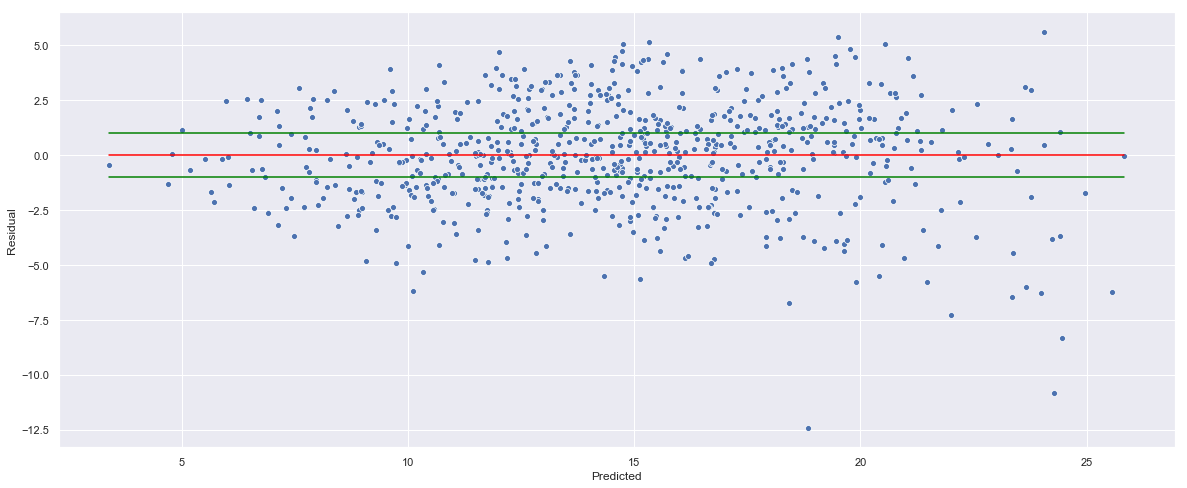

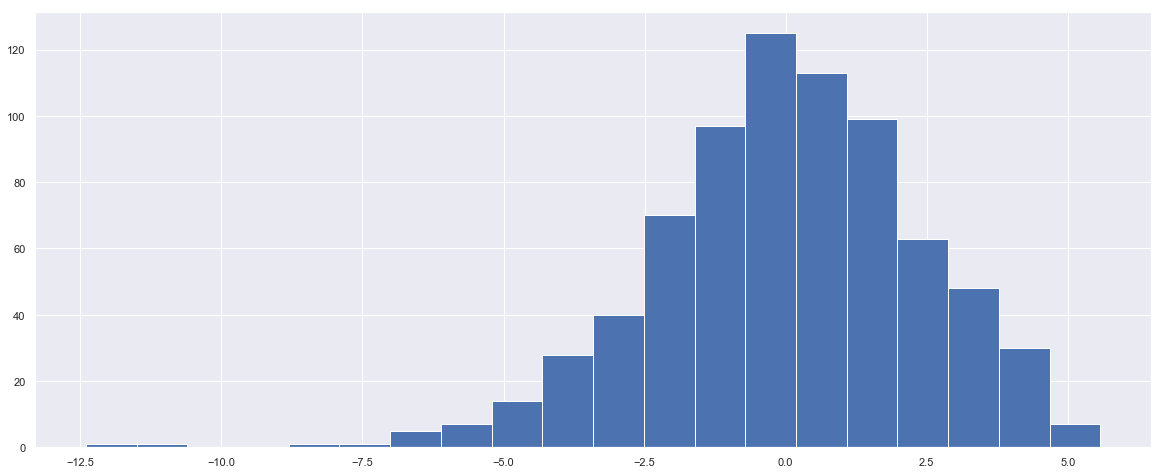

In [12]:
plan = vtreat.NumericOutcomeTreatment(
    outcome_name=target
)

fe = VtreatTransformer(plan)
ridge = Ridge(alpha=0.5)
pipe3 = make_pipeline(fe, scaler, ridge)

pipe3 = model_evaluate(pipe3, bagging=False)
y_pred = model_predict(pipe3)
plot_residuals()

In [13]:
# reset
used_cols = [c for c in used_cols if "_" not in c]
df = df[used_cols + [target]]
X, y = df[used_cols], df[target]
gc.collect();
peek()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.569760,0.709441,0.603974,0.556148,0.423655,0.645894,0.437587,0.891773,0.963663,0.383442,17.568016
1,0.063374,0.094139,0.042182,0.841182,0.778157,0.870012,0.978618,0.799159,0.461479,0.780529,17.369746
2,0.519512,0.409533,0.246501,0.773580,0.456150,0.568434,0.018790,0.617635,0.612096,0.616934,17.772757
747,0.319304,0.177424,0.091115,0.696922,0.993262,0.391915,0.763739,0.654240,0.420962,0.048934,16.919377
748,0.579745,0.956302,0.583319,0.190124,0.951614,0.187940,0.128146,0.362451,0.434851,0.977373,16.852105
749,0.086700,0.123346,0.995569,0.862306,0.345718,0.832780,0.899867,0.923395,0.875206,0.186220,15.818729


## (GLMs) Generalized Linear Models

![](https://www.explainxkcd.com/wiki/images/2/24/curve_fitting.png)

* https://en.wikipedia.org/wiki/Generalized_linear_model#Examples

* See also: https://en.wikipedia.org/wiki/Polynomial_and_rational_function_modeling#See_also

![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT8xwVqBSUCMnts2eOGq8ZnNLGTUlds-OUi-IgfscgKn2GzNlmP)

### (MARS) Multivariate Adaptive Regression Splines

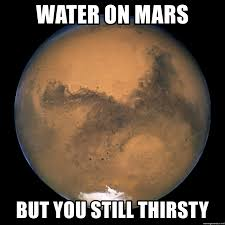

* https://en.wikipedia.org/wiki/Multivariate_adaptive_regression_spline#Pros_and_cons

* http://contrib.scikit-learn.org/py-earth/

In [14]:
from pyearth import Earth

------------------------------------------------------------
test_r2 :
					 0.9032 +/- 0.0243
train_r2 :
					 0.9269 +/- 0.0105

------------------------------------------------------------
test_neg_mean_absolute_error :
					 -1.1022 +/- 0.0686
train_neg_mean_absolute_error :
					 -1.0054 +/- 0.0633

------------------------------------------------------------
test_neg_mean_squared_error :
					 -2.1539 +/- 0.4384
train_neg_mean_squared_error :
					 -1.6500 +/- 0.1819

------------------------------------------------------------


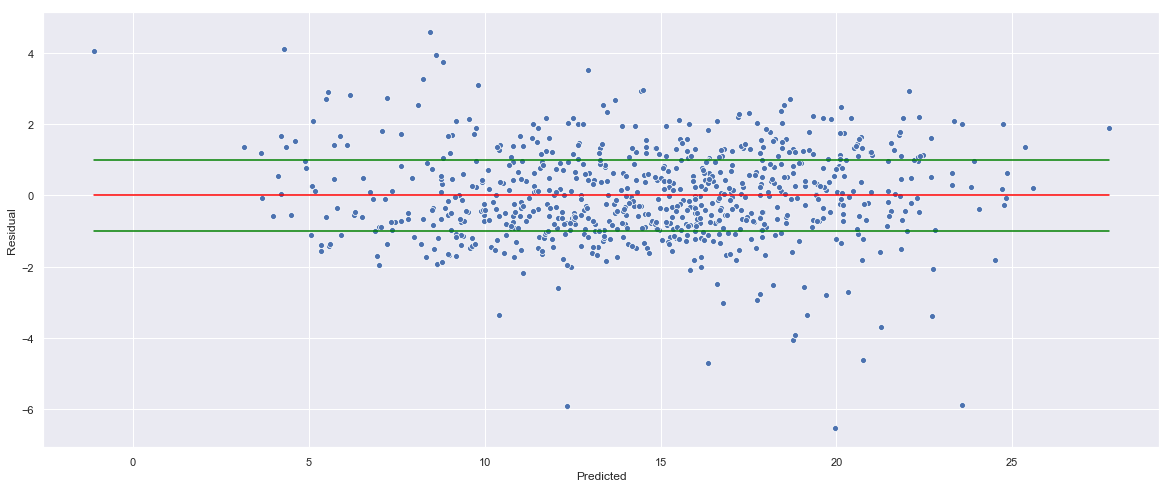

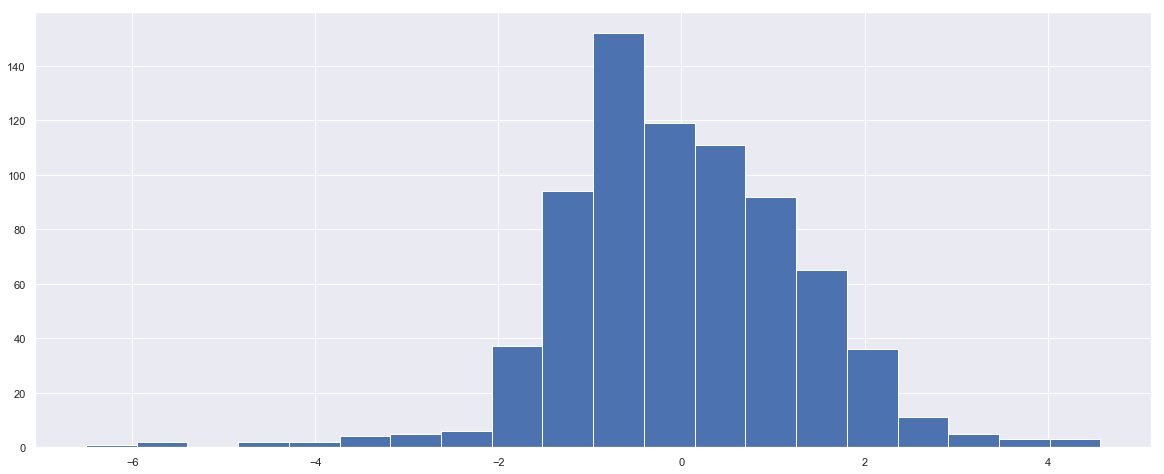

In [15]:
criteria = ('rss', 'nb_subsets')

mars1 = Earth(max_degree=1,
             feature_importance_type=criteria)
pipe4 = make_pipeline(scaler, mars1)
pipe4 = model_evaluate(pipe4, bagging=False)
y_pred = model_predict(pipe4)
plot_residuals()

In [16]:
mars1.fit(X,y)
print(mars1.summary())
print(mars1.summary_feature_importances(sort_by='nb_subsets'))

Earth Model
--------------------------------------
Basis Function   Pruned  Coefficient  
--------------------------------------
(Intercept)      No      3.03161      
x4               No      9.72208      
h(x2-0.352818)   No      6.84785      
h(0.352818-x2)   No      -14.0425     
h(x1-0.526206)   No      1.82208      
h(0.526206-x1)   No      -11.8174     
h(x3-0.442154)   No      -10.386      
h(0.442154-x3)   No      21.5157      
x5               No      4.73682      
h(x2-0.672212)   No      -8.23823     
h(0.672212-x2)   Yes     None         
h(x3-0.745827)   No      11.8759      
h(0.745827-x3)   Yes     None         
h(x3-0.151902)   No      13.8208      
h(0.151902-x3)   Yes     None         
h(x1-0.845308)   No      -7.39571     
h(0.845308-x1)   Yes     None         
h(x10-0.735431)  No      1.61481      
h(0.735431-x10)  Yes     None         
--------------------------------------
MSE: 1.7124, GCV: 1.8763, RSQ: 0.9245, GRSQ: 0.9175
        rss    nb_subsets
x3      0.11 

***Note*:** Notice how split-up *x3* is (and *x1* and *x2*). 
There seems to be some non-linear relationships between these variables and the target. 

Let's add a degree of complexity to the model.

------------------------------------------------------------
test_r2 :
					 0.9894 +/- 0.0016
train_r2 :
					 0.9919 +/- 0.0018

------------------------------------------------------------
test_neg_mean_absolute_error :
					 -0.3718 +/- 0.0347
train_neg_mean_absolute_error :
					 -0.3341 +/- 0.0343

------------------------------------------------------------
test_neg_mean_squared_error :
					 -0.2391 +/- 0.0303
train_neg_mean_squared_error :
					 -0.1846 +/- 0.0414

------------------------------------------------------------


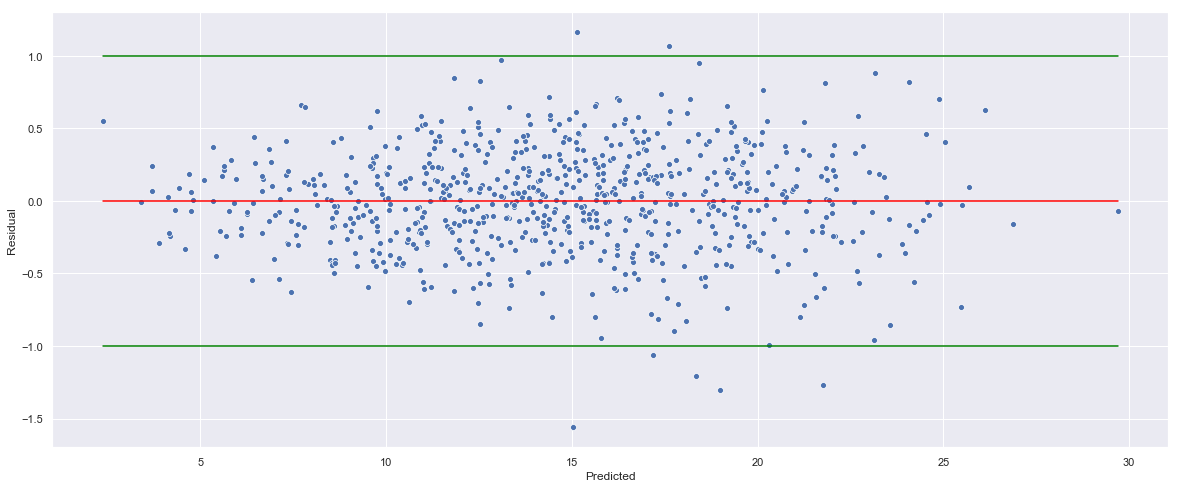

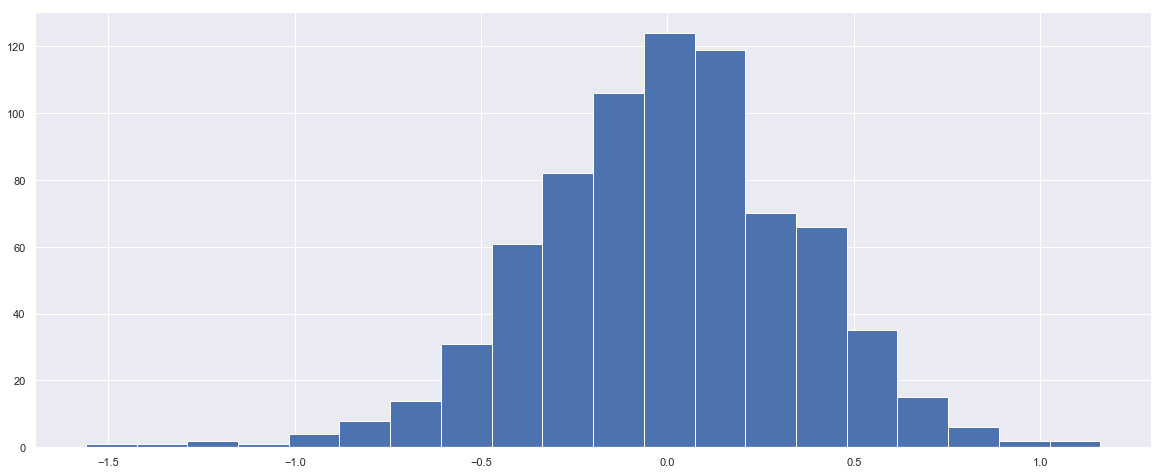

In [17]:
mars2 = Earth(max_degree=2,
             feature_importance_type=criteria)
pipe5 = make_pipeline(scaler, mars2)
pipe5 = model_evaluate(pipe5, bagging=False)
y_pred = model_predict(pipe5)
plot_residuals()

In [18]:
mars2.fit(X,y)
print(mars2.summary())
print(mars2.summary_feature_importances(sort_by='nb_subsets'))

Earth Model
----------------------------------------------------
Basis Function                 Pruned  Coefficient  
----------------------------------------------------
(Intercept)                    No      8.2397       
x4                             No      9.85156      
h(x2-0.352818)                 No      17.3194      
h(0.352818-x2)                 No      6.9872       
h(x1-0.526206)                 No      10.5169      
h(0.526206-x1)                 No      -10.2096     
h(x3-0.442154)                 Yes     None         
h(0.442154-x3)                 No      1.3622       
x5                             No      4.94672      
h(x1-0.483989)*h(x2-0.352818)  Yes     None         
h(0.483989-x1)*h(x2-0.352818)  No      -38.1861     
x1*h(0.352818-x2)              No      -29.0211     
x2*h(x2-0.352818)              No      -11.1022     
h(x3-0.583848)*h(x3-0.442154)  No      20.8256      
h(0.583848-x3)*h(x3-0.442154)  No      -35.3204     
h(x3-0.415782)*h(0.442154-x3)  Yes

***Note*:** It should be clear by now that:

* *x6*, *x7*, *x8*, *x9*, and *x10* are useless,
* *x1*, *x2*, and *x3* are our most important variables,
* *x1* and *x2* have an apparent interaction,
* *x3* interacts with itself,
* *x5* is the weakest informative feature.

Let's double-check at a higher degree of complexity.

------------------------------------------------------------
test_r2 :
					 0.9930 +/- 0.0009
train_r2 :
					 0.9943 +/- 0.0009

------------------------------------------------------------
test_neg_mean_absolute_error :
					 -0.2984 +/- 0.0244
train_neg_mean_absolute_error :
					 -0.2759 +/- 0.0175

------------------------------------------------------------
test_neg_mean_squared_error :
					 -0.1576 +/- 0.0203
train_neg_mean_squared_error :
					 -0.1280 +/- 0.0204

------------------------------------------------------------


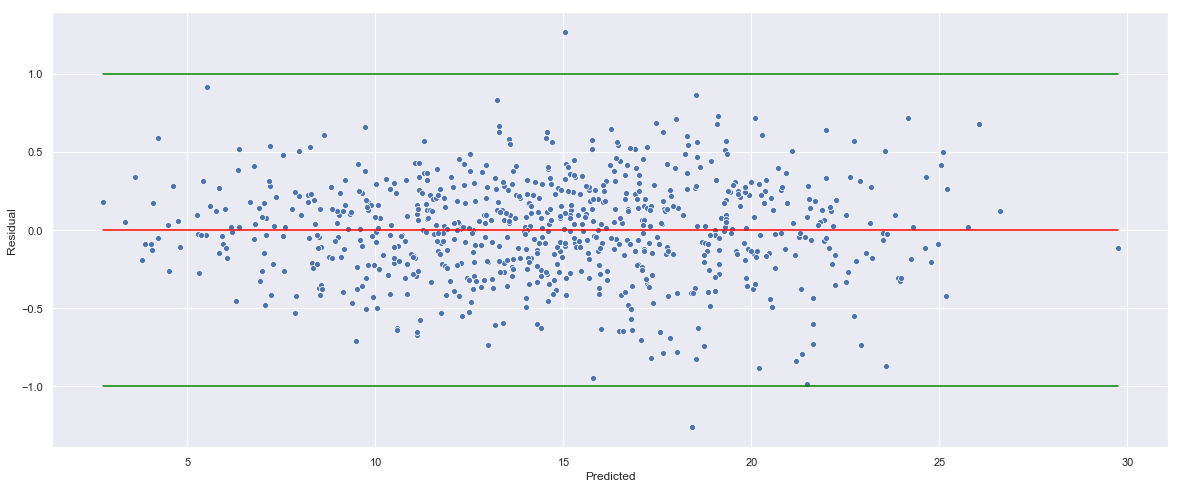

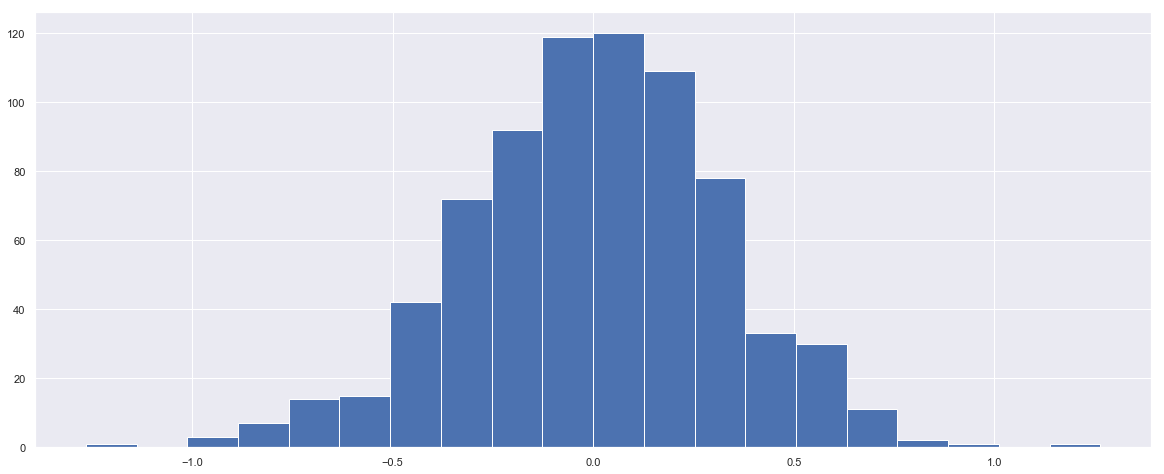

In [19]:
mars3 = Earth(max_degree=3,
             feature_importance_type=criteria)
pipe6 = make_pipeline(scaler, mars3)
pipe6 = model_evaluate(pipe6, bagging=False)
y_pred = model_predict(pipe6)
plot_residuals()

In [20]:
mars3.fit(X,y)
print(mars3.summary())
print(mars3.summary_feature_importances(sort_by='nb_subsets'))

Earth Model
-------------------------------------------------------------------
Basis Function                                Pruned  Coefficient  
-------------------------------------------------------------------
(Intercept)                                   No      6.60906      
x4                                            No      9.92004      
h(x2-0.352818)                                No      7.9972       
h(0.352818-x2)                                Yes     None         
h(x1-0.526206)                                No      -4.08081     
h(0.526206-x1)                                No      -11.4333     
h(x3-0.442154)                                Yes     None         
h(0.442154-x3)                                No      10.5704      
x5                                            No      4.90939      
h(x1-0.483989)*h(x2-0.352818)                 No      72.8898      
h(0.483989-x1)*h(x2-0.352818)                 No      -4.50352     
x1*h(0.352818-x2)                   

### (GAMs) Generalized Additive Models

![](https://biol609.github.io/lectures/images/gams/gam_gam_style.jpg)

* https://en.wikipedia.org/wiki/Generalized_additive_model

* https://pygam.readthedocs.io/en/latest/

* See also: https://multithreaded.stitchfix.com/blog/2015/07/30/gam/

* See also: 
    * https://en.wikipedia.org/wiki/Spline_(mathematics)
    * https://en.wikipedia.org/wiki/B-spline

In [21]:
from pygam import LinearGAM


gam = LinearGAM(n_splines=25).gridsearch(X.values, y.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     33.3296
Link Function:                     IdentityLink Log Likelihood:                                 -1313.0393
Number of Samples:                          750 AIC:                                             2694.7378
                                                AICc:                                             2698.132
                                                GCV:                                                1.8992
                                                Scale:                                              1.7479
                                                Pseudo R-Squared:                                   0.9263
Feature Function                  Lam

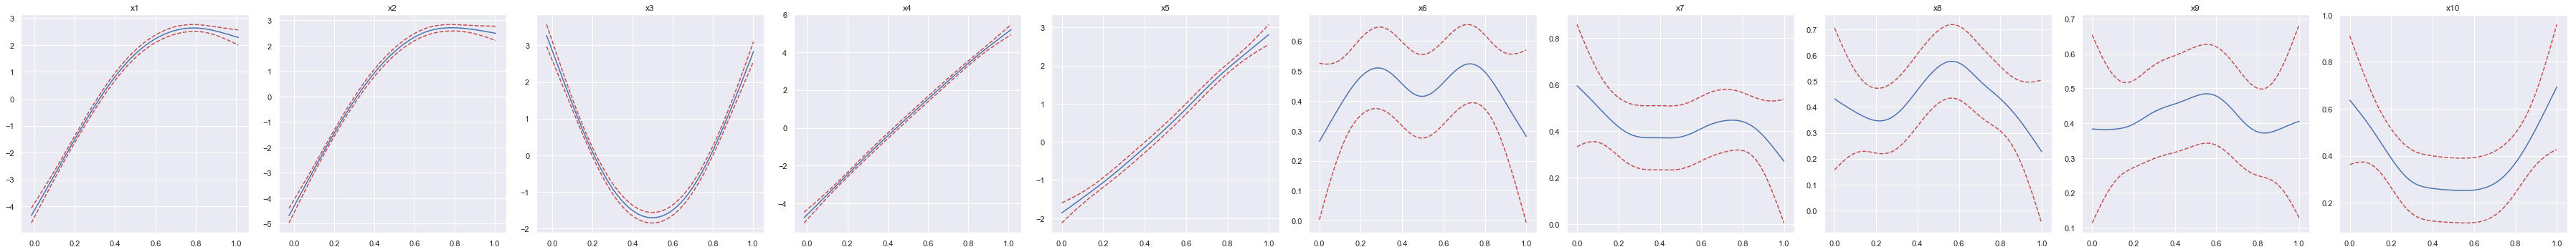

In [22]:
## plotting
N = len(used_cols)
fig, axs = plt.subplots(1,N,figsize=(N*5,5))

titles = used_cols
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
fig.tight_layout()
fig.show()

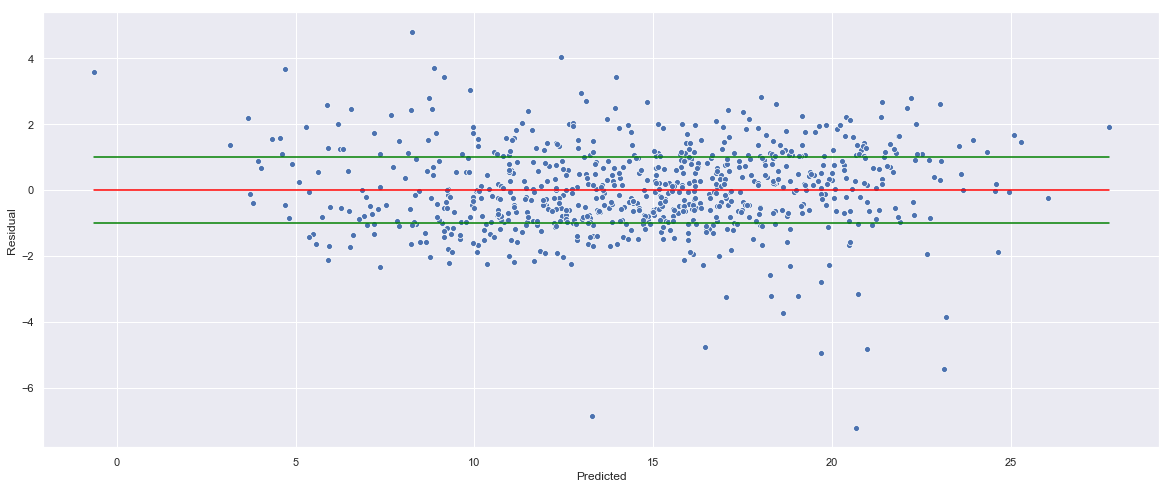

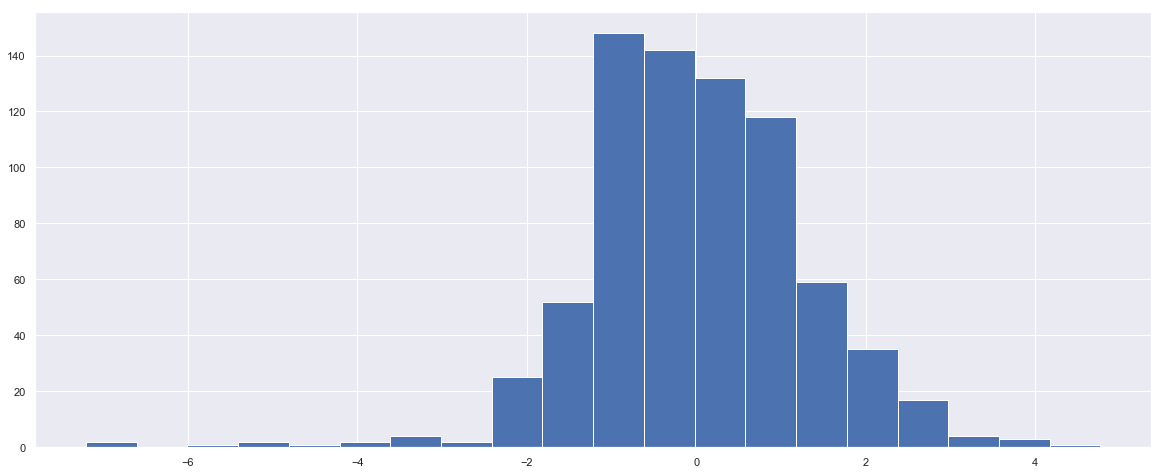

In [23]:
y_pred = model_predict([gam])
plot_residuals()

In [24]:
# Playing with distribution assumptions and link functions
from pygam import GAM


gam = GAM(distribution='gamma', link='log').gridsearch(X.values, y.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                     37.9617
Link Function:                          LogLink Log Likelihood:                                 -1445.4556
Number of Samples:                          750 AIC:                                             2968.8345
                                                AICc:                                            2973.2201
                                                GCV:                                                0.0169
                                                Scale:                                              0.0147
                                                Pseudo R-Squared:                                   0.8837
Feature Function                  Lam

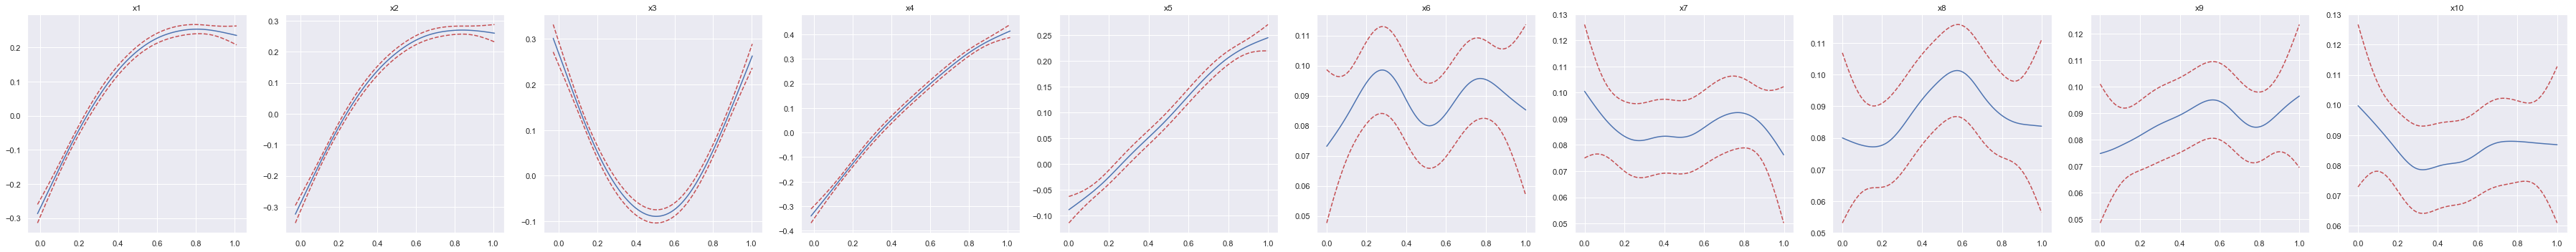

In [25]:
## plotting
N = len(used_cols)
fig, axs = plt.subplots(1,N,figsize=(N*5,5))

titles = used_cols
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
fig.tight_layout()
fig.show()

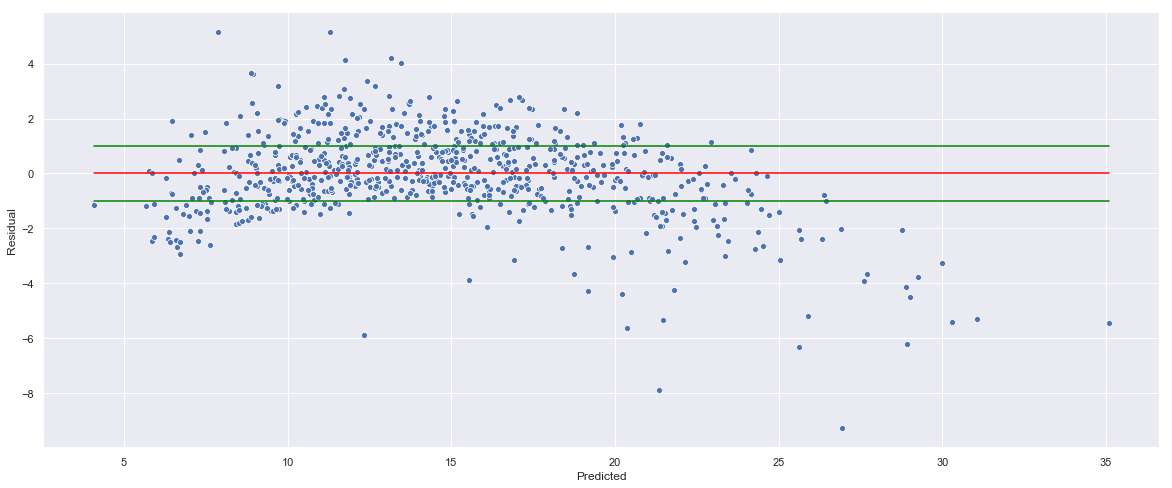

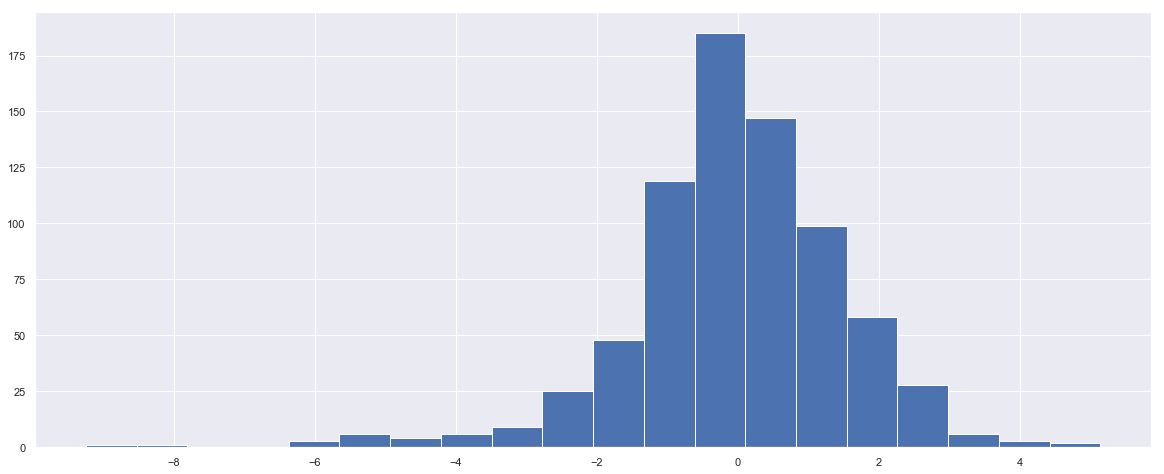

In [26]:
y_pred = model_predict([gam])
plot_residuals()

In [27]:
from pygam.terms import s as spline
from pygam.terms import f as factor
from pygam.terms import te as tensor


# DEFINE TERMS:
#   * splines - for continuous
#   * factors - for categorical/discrete 
#        (assumption: label encoded w/ 0 to level_size-1)
#   * tensors - for any interactions

# create the term list
term_list = []
for i, col in enumerate(used_cols):
    term_list.append(spline(i))

# add the x1 and x2 interaction term
term_list.append(tensor(0, 1))

# create the terms and model
terms = np.sum(term_list)
gam = LinearGAM(terms=terms).gridsearch(X.values, y.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    126.1193
Link Function:                     IdentityLink Log Likelihood:                                 -2544.4095
Number of Samples:                          750 AIC:                                             5343.0576
                                                AICc:                                            5395.4356
                                                GCV:                                                0.1196
                                                Scale:                                               0.084
                                                Pseudo R-Squared:                                   0.9969
Feature Function                  Lam

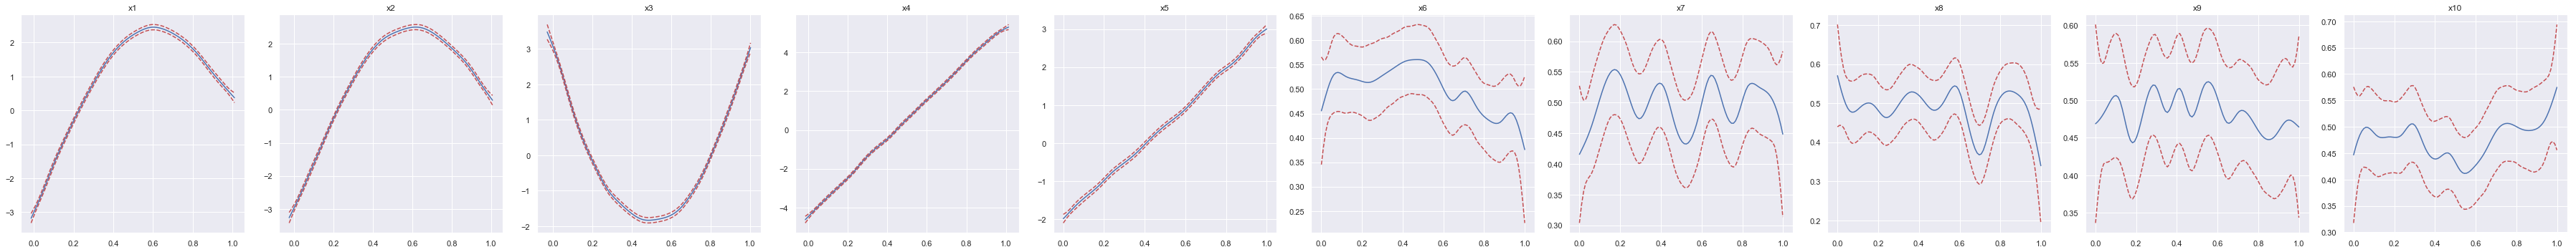

In [28]:
## plotting
N = len(used_cols)
fig, axs = plt.subplots(1,N,figsize=(N*5,5))

titles = used_cols
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
fig.tight_layout()
fig.show()

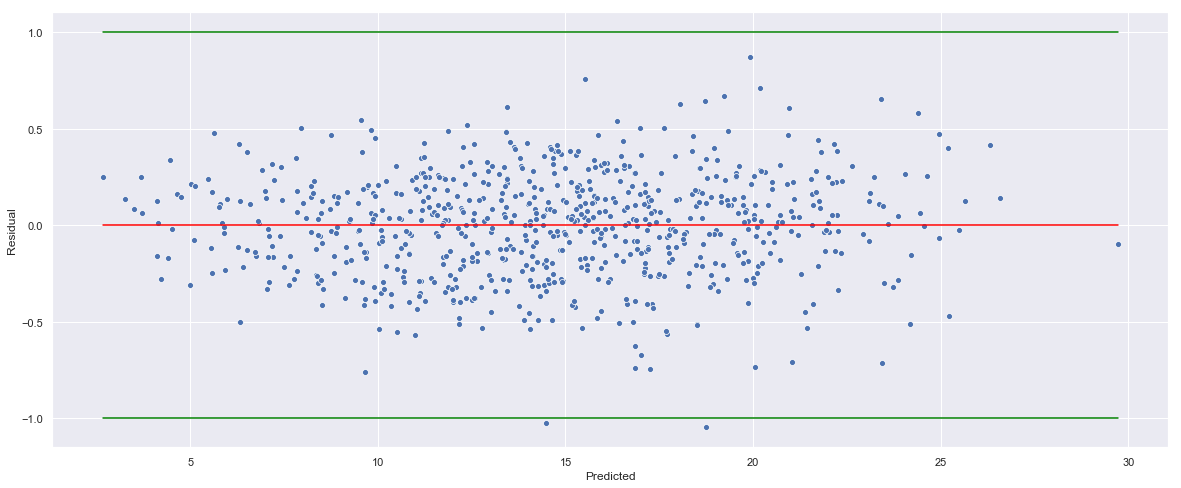

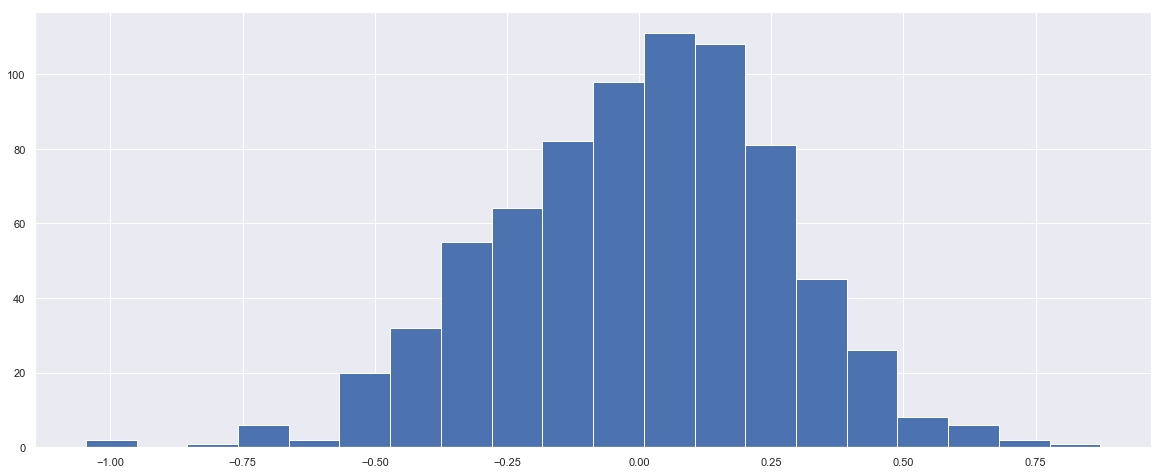

In [29]:
y_pred = model_predict([gam])
plot_residuals()

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     89.5625
Link Function:                     IdentityLink Log Likelihood:                                 -2994.5956
Number of Samples:                          750 AIC:                                             6170.3163
                                                AICc:                                            6195.5036
                                                GCV:                                                0.0995
                                                Scale:                                              0.0783
                                                Pseudo R-Squared:                                    0.997
Feature Function                  Lam

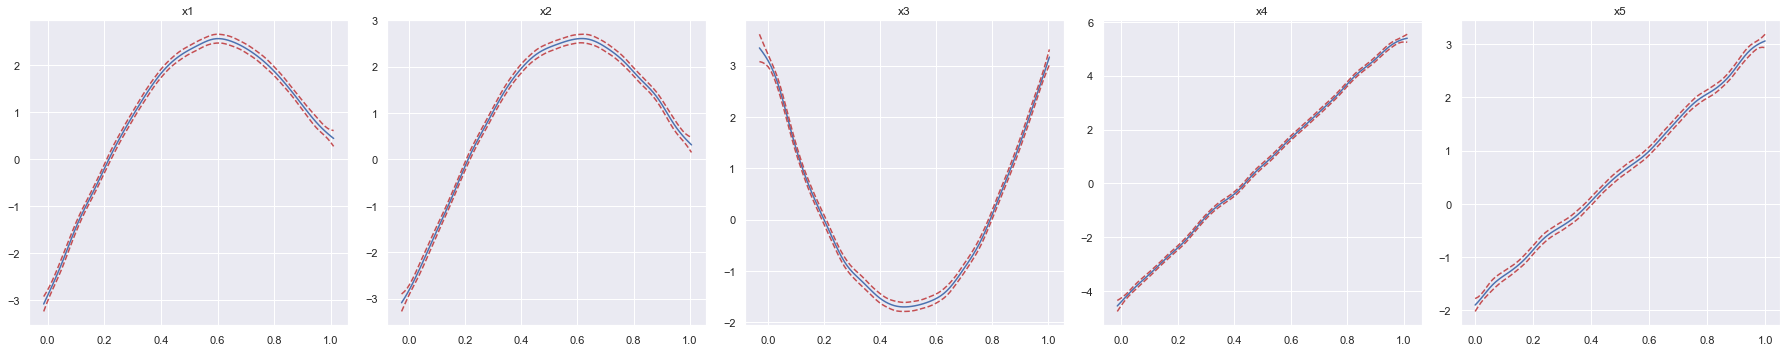

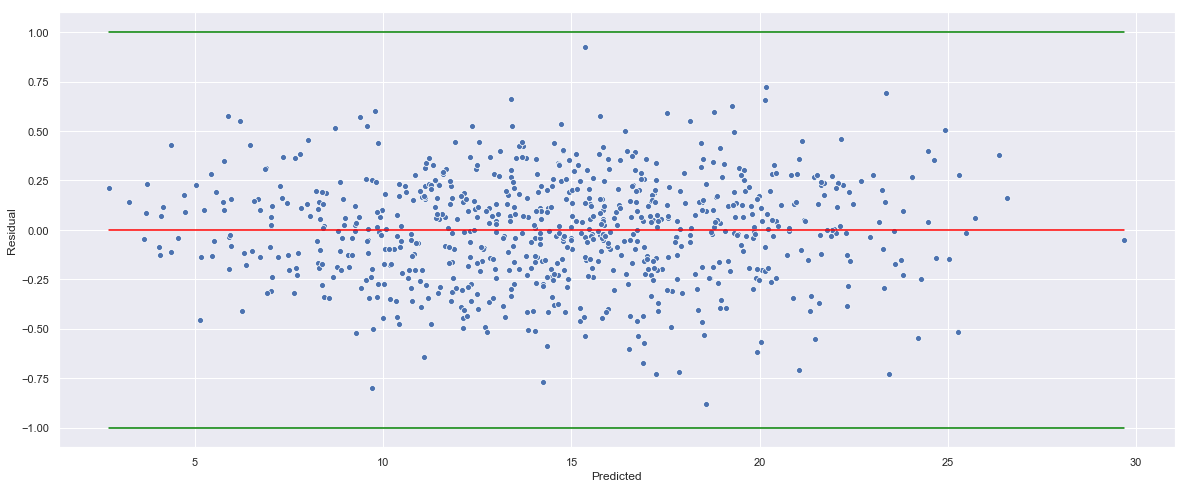

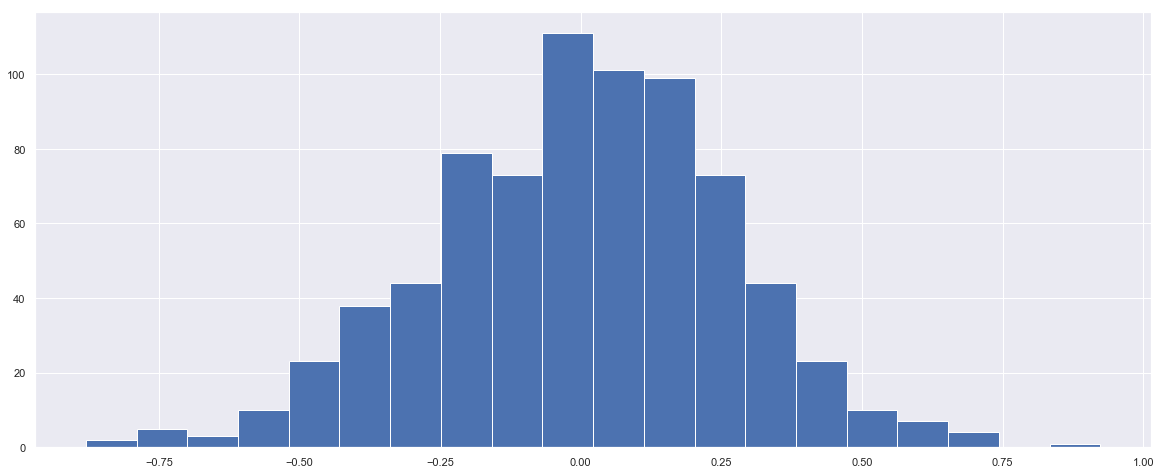

In [30]:
# remove the apparently useless features
used_cols = ['x%s' % (i+1) for i in range(5)]
df = df[used_cols + [target]]
X, y = df[used_cols], df[target]
gc.collect();

# create a new term list
term_list = []
for i, col in enumerate(used_cols):
    term_list.append(spline(i))
        
# add the interaction between x1 and x2
term_list.append(tensor(0, 1))

# create the terms and model
terms = np.sum(term_list)
gam = LinearGAM(terms=terms).gridsearch(X.values, y.values)
gam.summary()

## plotting
N = len(used_cols)
fig, axs = plt.subplots(1,N,figsize=(N*5,5))

titles = used_cols
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
fig.tight_layout()
fig.show()

y_pred = model_predict([gam])
plot_residuals()